In [1]:
import glob, h5py, math, time, os, json, argparse, datetime
import numpy as np
from FLKutils import *
from SampleUtils import *

import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

from tqdm import tqdm

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Data loading

In [26]:
import uproot
def load_data(name):
    base=f"/n/home11/sambt/contrastive_anomaly/training_JetClass/nate_scripts/trainings/kinpid/{name}/predict_output/"
    fQCD = uproot.open(base+"pred_contrastive_embedding_ZJetsToNuNu.root")["Events"]
    fW = uproot.open(base+"pred_contrastive_embedding_WToQQ.root")["Events"]
    fZ = uproot.open(base+"pred_contrastive_embedding_ZToQQ.root")["Events"]
    fT = uproot.open(base+"pred_contrastive_embedding_TTBar.root")["Events"]
    fHb = uproot.open(base+"pred_contrastive_embedding_HToBB.root")["Events"]
    
    key = 'embeddings'
    eQCD = fQCD[key].array().to_numpy()
    eW = fW[key].array().to_numpy()
    eZ = fZ[key].array().to_numpy()
    eT = fT[key].array().to_numpy()
    eHb = fHb[key].array().to_numpy()
    
    data = np.concatenate([eQCD,eW,eZ,eT,eHb],axis=0)
    labels = np.concatenate([0*np.ones(eQCD.shape[0]),1*np.ones(eW.shape[0]),2*np.ones(eZ.shape[0]),3*np.ones(eT.shape[0]),4*np.ones(eHb.shape[0])],axis=0).astype(int)
    
    shuf = np.random.permutation(data.shape[0])
    
    return data[shuf], labels[shuf]

In [27]:
d8_t05 = "ParT_contrastive_outDim8_temp0.05/20241025-103500_ParT_embedder_46af587c0682e0beccd786dc5ac8abc1_adamW_lr0.0005_batch512"
d2_t05 = "ParT_contrastive_outDim2_temp0.05/20241025-103500_ParT_embedder_46af587c0682e0beccd786dc5ac8abc1_adamW_lr0.0005_batch512"
d32_t05 = "ParT_contrastive_outDim32_temp0.05/20241025-103500_ParT_embedder_46af587c0682e0beccd786dc5ac8abc1_adamW_lr0.0005_batch512"
d2_t1 = "ParT_contrastive_outDim2_temp0.1/20241025-092604_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512"
d32_t1 = "ParT_contrastive_outDim32_temp0.1/20241025-092618_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512"
d16_t1 = "ParT_contrastive_outDim16_temp0.1/20241025-092614_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512"
d4_t1 = "ParT_contrastive_outDim4_temp0.1/20241025-092604_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512"
d4_t05 = "ParT_contrastive_outDim4_temp0.05/20241025-103500_ParT_embedder_46af587c0682e0beccd786dc5ac8abc1_adamW_lr0.0005_batch512"
d8_t1 = "ParT_contrastive_outDim8_temp0.1/20241025-092604_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512"
d16_t05 = "ParT_contrastive_outDim16_temp0.05/20241025-103500_ParT_embedder_46af587c0682e0beccd786dc5ac8abc1_adamW_lr0.0005_batch512"

# Problem setup

In [55]:
# labels identifying the signal classes in the dataset
sig_labels=[4]
# labels identifying the background classes in the dataset
bkg_labels=[0, 1, 2, 3]

# hyper parameters of the NPLM model based on kernel methods
## number of kernels
M = 1000 

## percentile of the distribution of pair-wise distances between reference-distributed points
flk_sigma_perc=90 

## L2 regularization coefficient
lam =1e-6 

## number of maximum iterations before the training is killed
iterations=1000000 
#iterations = 1000

## number of toys to simulate 
## (multiple experiments allow you to build a statistics for the test and quantify type I and II errors)
Ntoys = 100


In [29]:
features, target = load_data(d4_t1)

In [30]:
np.unique(target)

array([0, 1, 2, 3, 4])

In [31]:
features.shape

(248320, 4)

In [32]:
target.shape

(248320,)

In [73]:
np.count_nonzero(target==4)

49664

In [33]:
# select SIG and BKG classes
mask_SIG = np.zeros_like(target)
mask_BKG = np.zeros_like(target)
for sig_label in sig_labels:
    mask_SIG += 1*(target==sig_label)
for bkg_label in bkg_labels:
    mask_BKG += 1*(target==bkg_label)

features_SIG = features[mask_SIG>0]
features_BKG = features[mask_BKG>0]
############ end load data

In [34]:
######## standardizes data
print('standardize')
features_mean, features_std = np.mean(features_BKG, axis=0), np.std(features_BKG, axis=0)
print('mean: ', features_mean)
print('std: ', features_std)
features_BKG = standardize(features_BKG, features_mean, features_std)
features_SIG = standardize(features_SIG, features_mean, features_std)



standardize
mean:  [-5.22344626  1.14751353 -1.8257269  -5.32658572]
std:  [2.22182653 1.83730505 1.99971436 3.16809514]


In [35]:
#### compute sigma hyper parameter from data
#### sigma is the gaussian kernels width. 
#### Following a heuristic, we set this hyperparameter to the 90% quantile of the distribution of pair-wise distances between bkg-distributed points
#### (see below)
#### This doesn't need modifications, but one could in principle change it (see https://arxiv.org/abs/2408.12296)
flk_sigma = candidate_sigma(features_BKG[:2000, :], perc=flk_sigma_perc)
print('flk_sigma', flk_sigma)

flk_sigma 3.9


# Training

## null hypothesis

In [57]:
N_ref = 10000 # number of reference datapoints (mixture of non-anomalous classes)
N_bkg = 1000 # number of backgroun datapoints in the data (mixture of non-anomalous classes present in the data)
N_sig = 0 # number of signal datapoints in the data (mixture of anomalous classes present in the data)
w_ref = N_bkg*1./N_ref

In [58]:
## run toys
print('Start running toys')
t0=np.array([])
seeds = np.random.randint(low=1, high=100000, size=(Ntoys,))
for i in tqdm(range(Ntoys)):
    seed = seeds[i]
    rng = np.random.default_rng(seed=seed)
    N_bkg_p = rng.poisson(lam=N_bkg, size=1)[0]
    N_sig_p = rng.poisson(lam=N_sig, size=1)[0]
    rng.shuffle(features_SIG)
    rng.shuffle(features_BKG)
    features_s = features_SIG[:N_sig_p, :]
    features_b = features_BKG[:N_bkg_p+N_ref, :]
    features  = np.concatenate((features_s,features_b), axis=0)

    label_R = np.zeros((N_ref,))
    label_D = np.ones((N_bkg_p+N_sig_p, ))
    labels  = np.concatenate((label_D,label_R), axis=0).reshape(-1,1)
    
    flk_config = get_logflk_config(M,flk_sigma,[lam],weight=w_ref,iter=[iterations],seed=None,cpu=False)
    t, pred = run_toy('t0', features, labels, weight=w_ref, seed=seed,
                      flk_config=flk_config, output_path='./', plot=False, savefig=False,
                      verbose=False)
    
    t0 = np.append(t0, t)

Start running toys


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  1%|          | 1/100 [00:00<00:31,  3.12it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  2%|▏         | 2/100 [00:00<00:31,  3.15it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  3%|▎         | 3/100 [00:00<00:30,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  4%|▍         | 4/100 [00:01<00:29,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  5%|▌         | 5/100 [00:01<00:29,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  6%|▌         | 6/100 [00:01<00:29,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  7%|▋         | 7/100 [00:02<00:28,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  8%|▊         | 8/100 [00:02<00:29,  3.15it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  9%|▉         | 9/100 [00:02<00:28,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 10%|█         | 10/100 [00:03<00:28,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 11%|█         | 11/100 [00:03<00:27,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 12%|█▏        | 12/100 [00:03<00:27,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 13%|█▎        | 13/100 [00:04<00:27,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 14%|█▍        | 14/100 [00:04<00:26,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 15%|█▌        | 15/100 [00:04<00:27,  3.12it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 16%|█▌        | 16/100 [00:05<00:26,  3.15it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 17%|█▋        | 17/100 [00:05<00:26,  3.16it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 18%|█▊        | 18/100 [00:05<00:26,  3.14it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 19%|█▉        | 19/100 [00:05<00:25,  3.12it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 20%|██        | 20/100 [00:06<00:25,  3.12it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 21%|██        | 21/100 [00:06<00:25,  3.13it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 22%|██▏       | 22/100 [00:06<00:24,  3.16it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 23%|██▎       | 23/100 [00:07<00:24,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 24%|██▍       | 24/100 [00:07<00:23,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 25%|██▌       | 25/100 [00:07<00:23,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 26%|██▌       | 26/100 [00:08<00:22,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 27%|██▋       | 27/100 [00:08<00:22,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 28%|██▊       | 28/100 [00:08<00:22,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 29%|██▉       | 29/100 [00:09<00:21,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 30%|███       | 30/100 [00:09<00:21,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 31%|███       | 31/100 [00:09<00:21,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 32%|███▏      | 32/100 [00:10<00:21,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 33%|███▎      | 33/100 [00:10<00:20,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 34%|███▍      | 34/100 [00:10<00:20,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 35%|███▌      | 35/100 [00:10<00:20,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 36%|███▌      | 36/100 [00:11<00:19,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 37%|███▋      | 37/100 [00:11<00:19,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 38%|███▊      | 38/100 [00:11<00:19,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 39%|███▉      | 39/100 [00:12<00:18,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 40%|████      | 40/100 [00:12<00:18,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 41%|████      | 41/100 [00:12<00:18,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 42%|████▏     | 42/100 [00:13<00:17,  3.26it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 43%|████▎     | 43/100 [00:13<00:17,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 44%|████▍     | 44/100 [00:13<00:17,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 45%|████▌     | 45/100 [00:14<00:17,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 46%|████▌     | 46/100 [00:14<00:16,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 47%|████▋     | 47/100 [00:14<00:16,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 48%|████▊     | 48/100 [00:14<00:16,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 49%|████▉     | 49/100 [00:15<00:15,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 50%|█████     | 50/100 [00:15<00:15,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 51%|█████     | 51/100 [00:15<00:15,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 52%|█████▏    | 52/100 [00:16<00:15,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 53%|█████▎    | 53/100 [00:16<00:14,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 54%|█████▍    | 54/100 [00:16<00:14,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 55%|█████▌    | 55/100 [00:17<00:13,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 56%|█████▌    | 56/100 [00:17<00:13,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 57%|█████▋    | 57/100 [00:17<00:13,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 58%|█████▊    | 58/100 [00:18<00:13,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 59%|█████▉    | 59/100 [00:18<00:12,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 60%|██████    | 60/100 [00:18<00:12,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 61%|██████    | 61/100 [00:19<00:12,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 62%|██████▏   | 62/100 [00:19<00:11,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 63%|██████▎   | 63/100 [00:19<00:11,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 64%|██████▍   | 64/100 [00:19<00:11,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 65%|██████▌   | 65/100 [00:20<00:10,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 66%|██████▌   | 66/100 [00:20<00:10,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 67%|██████▋   | 67/100 [00:20<00:10,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 68%|██████▊   | 68/100 [00:21<00:09,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 69%|██████▉   | 69/100 [00:21<00:09,  3.26it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 70%|███████   | 70/100 [00:21<00:09,  3.26it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 71%|███████   | 71/100 [00:22<00:08,  3.26it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 72%|███████▏  | 72/100 [00:22<00:08,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 73%|███████▎  | 73/100 [00:22<00:08,  3.24it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 74%|███████▍  | 74/100 [00:23<00:07,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 75%|███████▌  | 75/100 [00:23<00:07,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 76%|███████▌  | 76/100 [00:23<00:07,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 77%|███████▋  | 77/100 [00:23<00:07,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 78%|███████▊  | 78/100 [00:24<00:06,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 79%|███████▉  | 79/100 [00:24<00:06,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 80%|████████  | 80/100 [00:24<00:06,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 81%|████████  | 81/100 [00:25<00:05,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 82%|████████▏ | 82/100 [00:25<00:05,  3.25it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 83%|████████▎ | 83/100 [00:25<00:05,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 84%|████████▍ | 84/100 [00:26<00:04,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 85%|████████▌ | 85/100 [00:26<00:04,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 86%|████████▌ | 86/100 [00:26<00:04,  3.23it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 87%|████████▋ | 87/100 [00:27<00:04,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 88%|████████▊ | 88/100 [00:27<00:03,  3.21it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 89%|████████▉ | 89/100 [00:27<00:03,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 90%|█████████ | 90/100 [00:28<00:03,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 91%|█████████ | 91/100 [00:28<00:02,  3.16it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 92%|█████████▏| 92/100 [00:28<00:02,  3.16it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 93%|█████████▎| 93/100 [00:28<00:02,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 94%|█████████▍| 94/100 [00:29<00:01,  3.17it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 95%|█████████▌| 95/100 [00:29<00:01,  3.18it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 96%|█████████▌| 96/100 [00:29<00:01,  3.19it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 97%|█████████▋| 97/100 [00:30<00:00,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 98%|█████████▊| 98/100 [00:30<00:00,  3.20it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 99%|█████████▉| 99/100 [00:30<00:00,  3.22it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


## alternative hypothesis (signal injection)

In [59]:
N_ref = 10000 # number of reference datapoints (mixture of non-anomalous classes)
N_bkg = 1000 # number of backgroun datapoints in the data (mixture of non-anomalous classes present in the data)
N_sig = 100 # number of signal datapoints in the data (mixture of anomalous classes present in the data)
w_ref = N_bkg*1./N_ref

In [60]:
## run toys
print('Start running toys')
t1=np.array([])
seeds = np.random.randint(low=1, high=100000, size=(Ntoys,))
for i in tqdm(range(Ntoys)):
    seed = seeds[i]
    rng = np.random.default_rng(seed=seed)
    N_bkg_p = rng.poisson(lam=N_bkg, size=1)[0]
    N_sig_p = rng.poisson(lam=N_sig, size=1)[0]
    rng.shuffle(features_SIG)
    rng.shuffle(features_BKG)
    features_s = features_SIG[:N_sig_p, :]
    features_b = features_BKG[:N_bkg_p+N_ref, :]
    features  = np.concatenate((features_s,features_b), axis=0)

    label_R = np.zeros((N_ref,))
    label_D = np.ones((N_bkg_p+N_sig_p, ))
    labels  = np.concatenate((label_D,label_R), axis=0).reshape(-1,1)
    
    flk_config = get_logflk_config(M,flk_sigma,[lam],weight=w_ref,iter=[iterations],seed=None,cpu=False)
    t, pred = run_toy("t1", features, labels, weight=w_ref, seed=seed,
                      flk_config=flk_config, output_path='./', plot=False, savefig=False,
                      verbose=True)
    
    t1 = np.append(t1, t)

Start running toys


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  1%|          | 1/100 [00:00<00:31,  3.10it/s]

toy 85856
---LRT = 47.33983999042516
---Time = 0.05 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  2%|▏         | 2/100 [00:00<00:32,  2.99it/s]

toy 96114
---LRT = 25.854207785979796
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  3%|▎         | 3/100 [00:00<00:31,  3.09it/s]

toy 73704
---LRT = 29.289789181906627
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  4%|▍         | 4/100 [00:01<00:30,  3.13it/s]

toy 48470
---LRT = 31.789108079662697
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  5%|▌         | 5/100 [00:01<00:30,  3.15it/s]

toy 71461
---LRT = 32.51670640846555
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  6%|▌         | 6/100 [00:01<00:29,  3.19it/s]

toy 6414
---LRT = 23.92477410723555
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  7%|▋         | 7/100 [00:02<00:29,  3.20it/s]

toy 23068
---LRT = 59.32798724997912
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  8%|▊         | 8/100 [00:02<00:28,  3.19it/s]

toy 65994
---LRT = 68.87842516984398
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


  9%|▉         | 9/100 [00:02<00:28,  3.18it/s]

toy 8111
---LRT = 51.776898507029685
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 10%|█         | 10/100 [00:03<00:28,  3.20it/s]

toy 39746
---LRT = 44.86467666743333
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 11%|█         | 11/100 [00:03<00:27,  3.19it/s]

toy 53852
---LRT = 22.16497220532637
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 12%|█▏        | 12/100 [00:03<00:27,  3.17it/s]

toy 35329
---LRT = 46.04578627681519
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 13%|█▎        | 13/100 [00:04<00:27,  3.17it/s]

toy 35854
---LRT = 32.116424796672476
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 14%|█▍        | 14/100 [00:04<00:27,  3.16it/s]

toy 19655
---LRT = 50.01715424347765
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 15%|█▌        | 15/100 [00:04<00:26,  3.17it/s]

toy 95147
---LRT = 35.164916812129945
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 16%|█▌        | 16/100 [00:05<00:26,  3.16it/s]

toy 51233
---LRT = 28.29042425392689
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 17%|█▋        | 17/100 [00:05<00:26,  3.17it/s]

toy 87376
---LRT = 20.8403555428975
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 18%|█▊        | 18/100 [00:05<00:25,  3.17it/s]

toy 46990
---LRT = 40.23520134767074
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 19%|█▉        | 19/100 [00:06<00:25,  3.16it/s]

toy 59367
---LRT = 37.75830157390533
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 20%|██        | 20/100 [00:06<00:25,  3.19it/s]

toy 81134
---LRT = 34.574432125862245
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 21%|██        | 21/100 [00:06<00:24,  3.22it/s]

toy 86246
---LRT = 38.62857810899243
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 22%|██▏       | 22/100 [00:06<00:24,  3.23it/s]

toy 39109
---LRT = 83.58372953026509
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 23%|██▎       | 23/100 [00:07<00:23,  3.24it/s]

toy 8325
---LRT = 31.712282896225247
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 24%|██▍       | 24/100 [00:07<00:23,  3.24it/s]

toy 85911
---LRT = 30.562041405216377
---Time = 0.03 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 25%|██▌       | 25/100 [00:07<00:23,  3.23it/s]

toy 41541
---LRT = 31.987168155788822
---Time = 0.03 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 26%|██▌       | 26/100 [00:08<00:22,  3.23it/s]

toy 47885
---LRT = 54.740413665676016
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 27%|██▋       | 27/100 [00:08<00:22,  3.23it/s]

toy 19712
---LRT = 48.10392785607715
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 28%|██▊       | 28/100 [00:08<00:22,  3.23it/s]

toy 39870
---LRT = 62.93098147249134
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 29%|██▉       | 29/100 [00:09<00:22,  3.23it/s]

toy 66112
---LRT = 84.96321856451311
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 30%|███       | 30/100 [00:09<00:21,  3.23it/s]

toy 38733
---LRT = 38.562770725953825
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 31%|███       | 31/100 [00:09<00:21,  3.23it/s]

toy 36083
---LRT = 35.04564574386815
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 32%|███▏      | 32/100 [00:10<00:21,  3.23it/s]

toy 79196
---LRT = 38.76634076661588
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 33%|███▎      | 33/100 [00:10<00:20,  3.23it/s]

toy 32042
---LRT = 46.808701571371216
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 34%|███▍      | 34/100 [00:10<00:20,  3.22it/s]

toy 6581
---LRT = 55.735651390218095
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 35%|███▌      | 35/100 [00:10<00:20,  3.21it/s]

toy 71441
---LRT = 33.722647418414866
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 36%|███▌      | 36/100 [00:11<00:19,  3.24it/s]

toy 44725
---LRT = 38.49061454815768
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 37%|███▋      | 37/100 [00:11<00:19,  3.25it/s]

toy 82000
---LRT = 56.211294972628366
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 38%|███▊      | 38/100 [00:11<00:19,  3.24it/s]

toy 46917
---LRT = 43.9963547989116
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 39%|███▉      | 39/100 [00:12<00:18,  3.25it/s]

toy 9583
---LRT = 37.38618968890371
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 40%|████      | 40/100 [00:12<00:18,  3.24it/s]

toy 35243
---LRT = 38.5281109416066
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 41%|████      | 41/100 [00:12<00:18,  3.23it/s]

toy 78165
---LRT = 55.757599865081204
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 42%|████▏     | 42/100 [00:13<00:17,  3.23it/s]

toy 82962
---LRT = 54.31784532745462
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 43%|████▎     | 43/100 [00:13<00:17,  3.25it/s]

toy 63581
---LRT = 41.66083546365178
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 44%|████▍     | 44/100 [00:13<00:17,  3.21it/s]

toy 38856
---LRT = 42.706946372931526
---Time = 0.05 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 45%|████▌     | 45/100 [00:14<00:17,  3.23it/s]

toy 12022
---LRT = 41.8049979841002
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 46%|████▌     | 46/100 [00:14<00:16,  3.25it/s]

toy 60804
---LRT = 74.00168799290233
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 47%|████▋     | 47/100 [00:14<00:16,  3.25it/s]

toy 91622
---LRT = 48.54251712684734
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 48%|████▊     | 48/100 [00:14<00:16,  3.24it/s]

toy 56133
---LRT = 26.48327175273718
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 49%|████▉     | 49/100 [00:15<00:15,  3.22it/s]

toy 22403
---LRT = 32.60701836711249
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 50%|█████     | 50/100 [00:15<00:15,  3.24it/s]

toy 23143
---LRT = 37.36021129741437
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 51%|█████     | 51/100 [00:15<00:15,  3.24it/s]

toy 39928
---LRT = 27.098722310512755
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 52%|█████▏    | 52/100 [00:16<00:14,  3.24it/s]

toy 74654
---LRT = 37.17258599032874
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 53%|█████▎    | 53/100 [00:16<00:14,  3.24it/s]

toy 1557
---LRT = 47.556845617265196
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 54%|█████▍    | 54/100 [00:16<00:14,  3.24it/s]

toy 74270
---LRT = 62.03858926808064
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 55%|█████▌    | 55/100 [00:17<00:13,  3.22it/s]

toy 53042
---LRT = 32.90672523884734
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 56%|█████▌    | 56/100 [00:17<00:13,  3.20it/s]

toy 84057
---LRT = 69.1698359033835
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 57%|█████▋    | 57/100 [00:17<00:13,  3.18it/s]

toy 99565
---LRT = 47.4216554861227
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 58%|█████▊    | 58/100 [00:18<00:13,  3.18it/s]

toy 18052
---LRT = 56.21252369413608
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 59%|█████▉    | 59/100 [00:18<00:12,  3.19it/s]

toy 1426
---LRT = 60.345760217528834
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 60%|██████    | 60/100 [00:18<00:12,  3.19it/s]

toy 83426
---LRT = 59.55064181571868
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 61%|██████    | 61/100 [00:19<00:12,  3.18it/s]

toy 88824
---LRT = 65.93542949624467
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 62%|██████▏   | 62/100 [00:19<00:11,  3.18it/s]

toy 34263
---LRT = 32.515242967075125
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 63%|██████▎   | 63/100 [00:19<00:11,  3.17it/s]

toy 76670
---LRT = 35.25933268179776
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 64%|██████▍   | 64/100 [00:19<00:11,  3.18it/s]

toy 41497
---LRT = 60.40901812533059
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 65%|██████▌   | 65/100 [00:20<00:10,  3.20it/s]

toy 42170
---LRT = 44.38623580544504
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 66%|██████▌   | 66/100 [00:20<00:10,  3.22it/s]

toy 22799
---LRT = 72.10283694463016
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 67%|██████▋   | 67/100 [00:20<00:10,  3.25it/s]

toy 10851
---LRT = 49.35872050857975
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 68%|██████▊   | 68/100 [00:21<00:09,  3.24it/s]

toy 19168
---LRT = 52.369050111486956
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 69%|██████▉   | 69/100 [00:21<00:09,  3.25it/s]

toy 57335
---LRT = 32.61784523921642
---Time = 0.03 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 70%|███████   | 70/100 [00:21<00:09,  3.23it/s]

toy 83533
---LRT = 26.858406197734254
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 71%|███████   | 71/100 [00:22<00:08,  3.24it/s]

toy 64457
---LRT = 20.33874515776523
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 72%|███████▏  | 72/100 [00:22<00:08,  3.24it/s]

toy 20598
---LRT = 31.067883524119168
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 73%|███████▎  | 73/100 [00:22<00:08,  3.24it/s]

toy 10377
---LRT = 51.826566311128715
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 74%|███████▍  | 74/100 [00:23<00:08,  3.24it/s]

toy 53049
---LRT = 59.10915431723339
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 75%|███████▌  | 75/100 [00:23<00:07,  3.25it/s]

toy 25394
---LRT = 22.848379393623333
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 76%|███████▌  | 76/100 [00:23<00:07,  3.23it/s]

toy 58074
---LRT = 63.44790358769001
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 77%|███████▋  | 77/100 [00:23<00:07,  3.21it/s]

toy 52871
---LRT = 54.622737998976106
---Time = 0.05 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 78%|███████▊  | 78/100 [00:24<00:06,  3.23it/s]

toy 65706
---LRT = 66.23495220919355
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 79%|███████▉  | 79/100 [00:24<00:06,  3.25it/s]

toy 96975
---LRT = 40.6560381571997
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 80%|████████  | 80/100 [00:24<00:06,  3.23it/s]

toy 60155
---LRT = 38.97448692467603
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 81%|████████  | 81/100 [00:25<00:05,  3.25it/s]

toy 28395
---LRT = 28.20145630403431
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 82%|████████▏ | 82/100 [00:25<00:05,  3.26it/s]

toy 93482
---LRT = 64.4840872271734
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 83%|████████▎ | 83/100 [00:25<00:05,  3.26it/s]

toy 34820
---LRT = 58.21084968627784
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 84%|████████▍ | 84/100 [00:26<00:04,  3.25it/s]

toy 6525
---LRT = 29.43668598742005
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 85%|████████▌ | 85/100 [00:26<00:04,  3.25it/s]

toy 97708
---LRT = 56.84757769883919
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 86%|████████▌ | 86/100 [00:26<00:04,  3.26it/s]

toy 68586
---LRT = 26.5111685734457
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 87%|████████▋ | 87/100 [00:27<00:04,  3.23it/s]

toy 87561
---LRT = 38.248145333421945
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 88%|████████▊ | 88/100 [00:27<00:03,  3.22it/s]

toy 23869
---LRT = 63.2578507648108
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 89%|████████▉ | 89/100 [00:27<00:03,  3.23it/s]

toy 93494
---LRT = 66.41232024325114
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 90%|█████████ | 90/100 [00:27<00:03,  3.25it/s]

toy 295
---LRT = 30.981009770912934
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 91%|█████████ | 91/100 [00:28<00:02,  3.25it/s]

toy 35230
---LRT = 48.56593590131328
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 92%|█████████▏| 92/100 [00:28<00:02,  3.23it/s]

toy 51141
---LRT = 71.13288500171328
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 93%|█████████▎| 93/100 [00:28<00:02,  3.23it/s]

toy 74850
---LRT = 57.44593704702942
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 94%|█████████▍| 94/100 [00:29<00:01,  3.21it/s]

toy 15625
---LRT = 53.70200596098553
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 95%|█████████▌| 95/100 [00:29<00:01,  3.23it/s]

toy 42711
---LRT = 39.09010158544811
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 96%|█████████▌| 96/100 [00:29<00:01,  3.25it/s]

toy 36283
---LRT = 42.35863642705587
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 97%|█████████▋| 97/100 [00:30<00:00,  3.26it/s]

toy 45041
---LRT = 40.67618516380466
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 98%|█████████▊| 98/100 [00:30<00:00,  3.23it/s]

toy 11632
---LRT = 38.87906508209511
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


 99%|█████████▉| 99/100 [00:30<00:00,  3.22it/s]

toy 85519
---LRT = 60.972296841147454
---Time = 0.04 sec
	
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]

toy 24400
---LRT = 63.45469121603345
---Time = 0.04 sec
	


# Plot results

In [62]:
def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def plot_1distribution(t, df, xmin=0, xmax=300, nbins=10, save=False, ymax=None, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    #plt.close(fig)
    #return

def plot_2distribution(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_chi2(np.median(t2), df)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.pdf')
    plt.show()
    #plt.close()
    #return #[Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m]

In [63]:
# plot null distribution
plot_1distribution(t0, df=np.mean(t0), xmin=0.9*np.min(t0), xmax=60, nbins=16, label='REF', save=True, ymax=None, output_path='./', save_name='test')

saved at ./test_distribution.pdf


In [64]:
# plot alternative vs null distributions
plot_2distribution(t0, t1, df=np.mean(t0), xmin=np.min(t0), xmax=np.max(t1)*1.1, #ymax=0.03, 
                   nbins=19, label1='REF', label2='BKG+SIG', print_Zscore=True,
                   save=True, output_path='./', save_name='test')

array([15.99646461, 18.99318622,  5.85134805, 14.12176316, 12.10554352,
       11.28612414,  5.77985815, 26.47464293, 13.69609329,  6.1102891 ,
       21.35271777, 17.95675839,  8.65597373, 11.00282698, 10.51465753,
       25.1108407 ,  7.60370311,  6.49557349, 16.87192539,  8.05473919,
       10.77508533, 16.38333098, 12.06819332, 11.72846645, 13.8745097 ,
       16.22926067, 14.87685038, 12.20711867,  7.06951332,  5.91142158,
       22.29179172, 20.36166491,  9.35695407,  4.94319746, 12.41977779,
       10.40605456, 13.52897181, 10.1540219 ,  7.39893623,  5.81765651,
       21.35489245,  5.51576872, 11.01215979,  7.50067676, 20.85715303,
       12.71223954,  9.09551962, 15.99835844, 12.20328778, 14.79885279,
       27.93588092, 11.6330539 , 13.81111612, 10.66337725,  7.55519857,
       14.03532841, 11.20248872, 10.75291046, 13.11491608, 18.08081757,
       20.70936156,  7.8659969 ,  3.91256072, 13.91309141,  7.60800429,
       13.22105183,  8.13153317, 13.54229311,  4.5741374 ,  5.69

# save files

In [ ]:
## details about the save path
folder_out = './out/'
sig_string = ''
if N_sig:
    sig_string+='_SIG'
    for s in sig_labels:
        sig_string+='-%i'%(s)
NP = '%s_NR%i_NB%i_NS%i_M%i_lam%s_iter%i/'%(sig_string, N_ref, N_bkg, N_sig,
                                                  M, str(lam), iterations)
if not os.path.exists(folder_out+NP):
    os.makedirs(folder_out+NP)

In [ ]:
np.save('%s/t0.npy'%(folder_out+NP), t0)
np.save('%s/t1.npy'%(folder_out+NP), t1)

# test

In [1]:
import glob, h5py, math, time, os, json, argparse, datetime
import matplotlib.pyplot as plt

base = "/n/home11/sambt/contrastive_anomaly/training_JetClass/nate_scripts/trainings/kinpid/ParT_contrastive_outDim4_temp0.1/20241025-092604_ParT_embedder_d45c6dde3e2a709e6fd40acaf05cc5a2_adamW_lr0.0005_batch512/NPLM/"

f0 = h5py.File(f"{base}/NPLM_d4_t1__NR50000_NB10000_NS0_M10000_lam1e-06_iter1000000/tvalues_flksigma3.9.h5","r")
f1 = h5py.File(f"{base}/NPLM_d4_t1_SIG-4_NR50000_NB10000_NS50_M10000_lam1e-06_iter1000000/tvalues_flksigma3.9.h5","r")


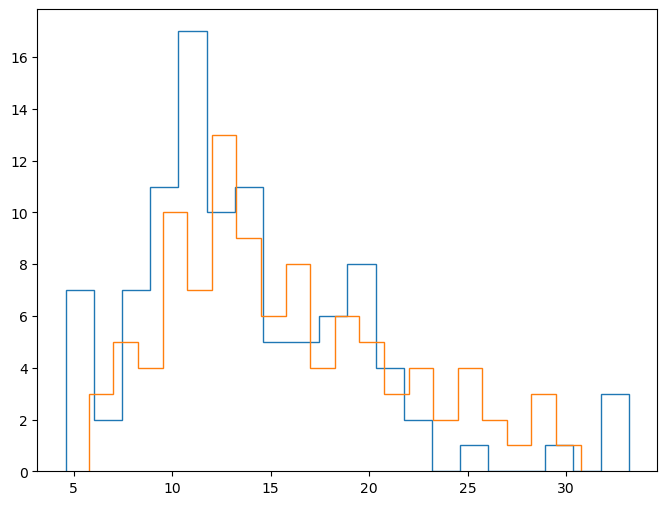

In [5]:
plt.figure(figsize=(8,6))

h0 = plt.hist(f0['3.9'][()],bins=20,histtype='step')
h1 = plt.hist(f1['3.9'][()],bins=20,histtype='step')

plt.show()